# Introduction to Hyperopt for Optimizing Neural Networks

## What is Hyperopt?

Hyperopt is a way to search through an hyperparameter space, for example with the [Tree-structured Parzen Estimator (TPE) algorithm](https://pdfs.semanticscholar.org/9f2a/efc3821853e963beda011ed770f740385b77.pdf), which explore intelligently the search space while narrowing down to the estimated best parameters. 

This is an oriented random search, in contrast with a Grid Search where hyperparameters are pre-established with fixed steps increase. [Random Search for Hyper-Parameter Optimization](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a) has proven to be an effective search technique. The paper about this technique [sits among the most cited deep learning papers](https://github.com/terryum/awesome-deep-learning-papers#optimization--training-techniques). 

## How to define Hyperopt parameters?

A parameter is defined with a certain uniformrange or else a probability distribution, such as: 
- hp.randint(label, upper)
- hp.uniform(label, low, high)
- hp.loguniform(label, low, high)
- hp.normal(label, mu, sigma)
- hp.lognormal(label, mu, sigma)

There is also a few quantized versions of those functions, which rounds the generated values at each step of "q":
- hp.quniform(label, low, high, q)
- hp.qloguniform(label, low, high, q)
- hp.qnormal(label, mu, sigma, q)
- hp.qlognormal(label, mu, sigma, q)

A visualisation of this can be found below. 

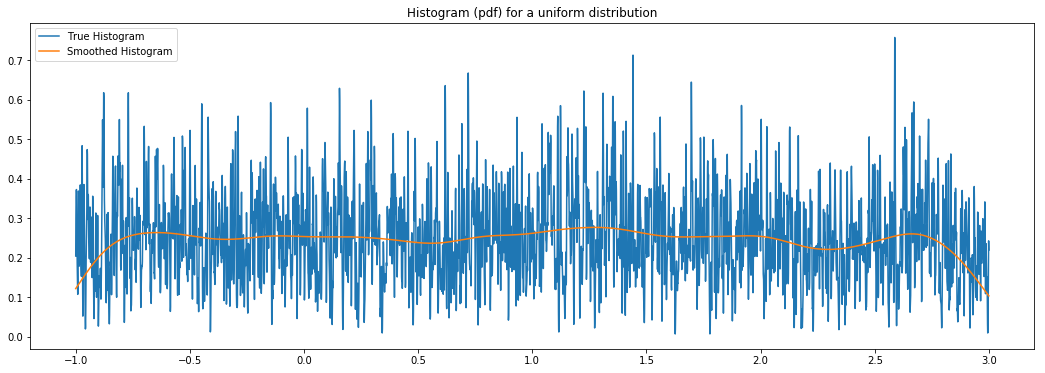

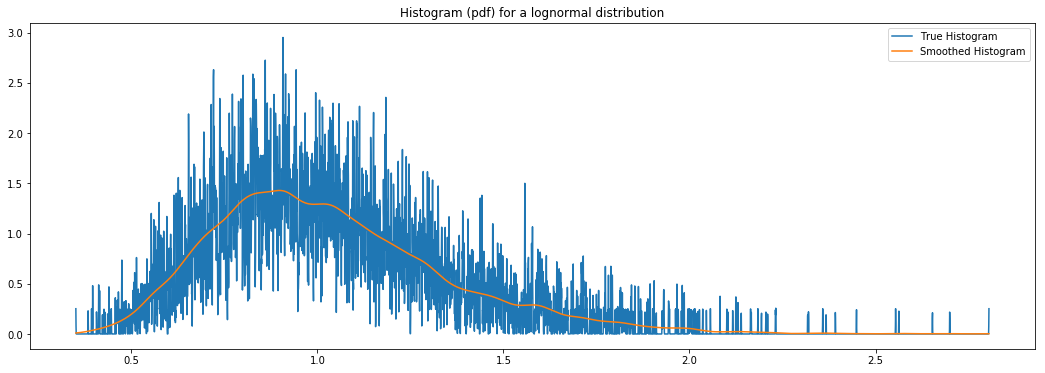

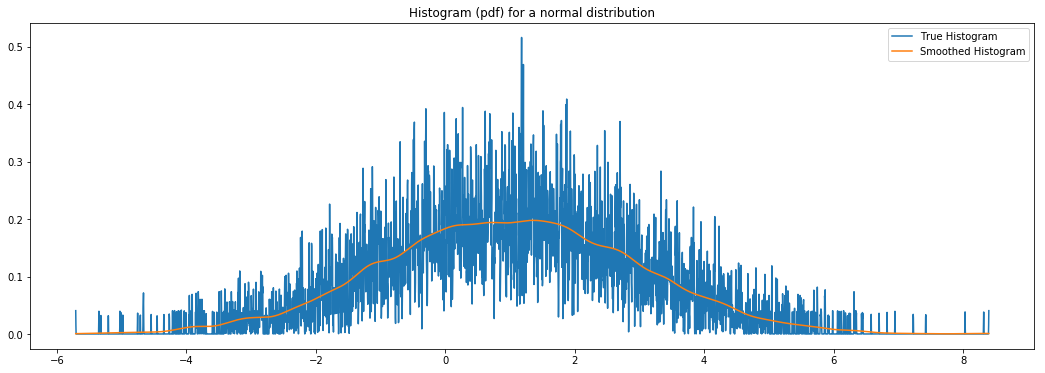

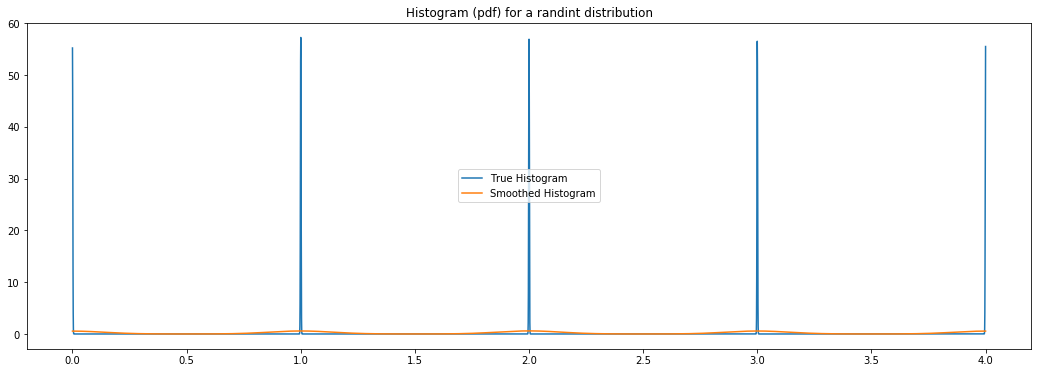

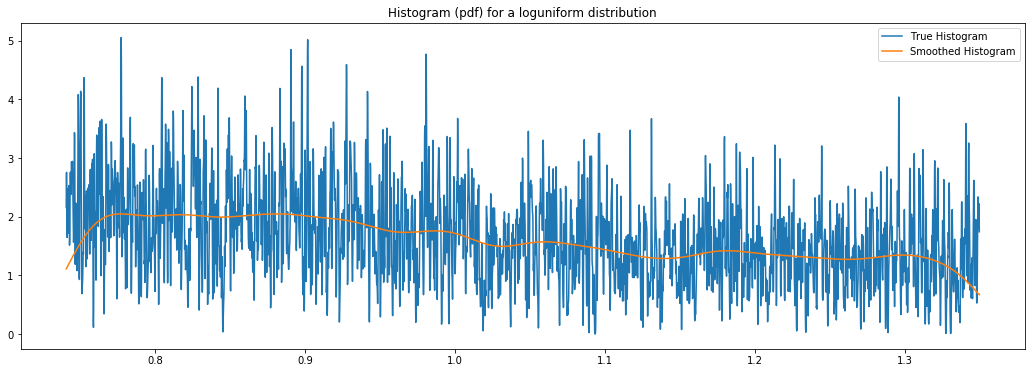

In [1]:
# The "%reset" ipython magic command will reset the kernel upon being called.
# (thus flushing loaded variables and previous imports from the current
# notebook session, if there were any)
%reset -f

from hyperopt import pyll, hp
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.kde import gaussian_kde

# Let's plot the result of sampling from many different probability distributions:
hyperparam_generators = {
    'randint': hp.randint('randint', 5),
    'uniform': hp.uniform('uniform', -1, 3),
    'loguniform': hp.loguniform('loguniform', -0.3, 0.3),
    'normal': hp.normal('normal', 1, 2),
    'lognormal': hp.lognormal('lognormal', 0, 0.3)
}

n_samples = 5000

for title, space in hyperparam_generators.items():
    evaluated = [
        pyll.stochastic.sample(space) for _ in range(n_samples)
    ]
    x_domain = np.linspace(min(evaluated), max(evaluated), n_samples)
    
    plt.figure(figsize=(18,6))
    
    hist = gaussian_kde(evaluated, 0.001)
    plt.plot(x_domain, hist(x_domain), label="True Histogram")
    
    blurred_hist = gaussian_kde(evaluated, 0.1)
    plt.plot(x_domain, blurred_hist(x_domain), label="Smoothed Histogram")
    
    plt.title("Histogram (pdf) for a {} distribution".format(title))
    plt.legend()
    plt.show()

Note on the above charts (especially for the loguniform and uniform distributions): the blurred line averaging the values fades out toward the ends of the signal since it is zero-padded. The line ideally would not fade out by using techniques such as mirror-padding. 

## On the loguniform and lognormal distributions

Those are the best distributions for modeling the values a learning rate. That's because we want to observe changes in the learning rate according to changing it with multiplications rather than additions, e.g.: when adjusting the learning rate, we'll want to try to divide it or multiply it by 2 rather than adding and substracting a finite value. 

To proove this, let's generate a loguniform distribution for a multiplier of the learning rate, centered at 1.0. Dividing 1 by those values should yield the same distribution.

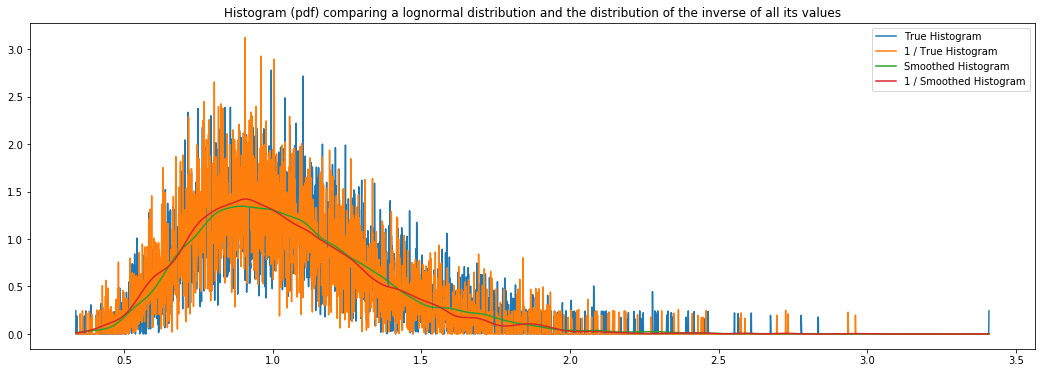

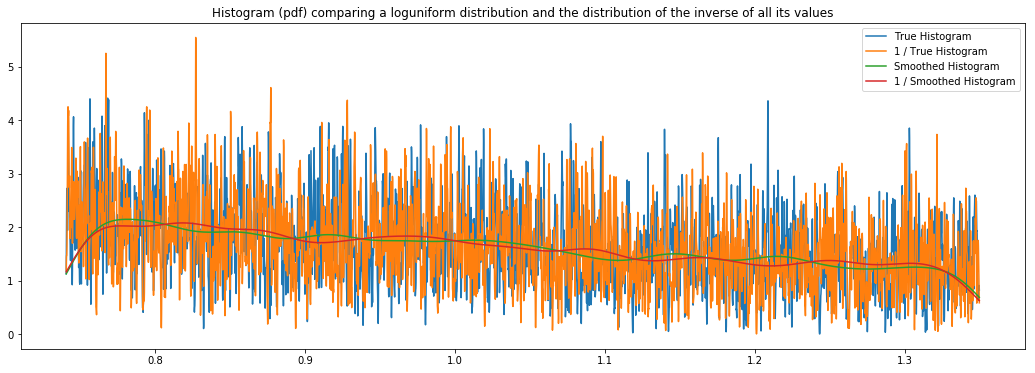

In [2]:
log_hyperparam_generators = {
    'loguniform': hp.loguniform('loguniform', -0.3, 0.3),
    'lognormal': hp.lognormal('lognormal', 0, 0.3)
}
# For more info about the lognormal distribution, see: 
# https://www.wolframalpha.com/input/?i=y%3D2%5E(+(-log4(x))%5E0.5+),+y%3D2%5E(-+(-log4(x))%5E0.5+)+from+0+to+1
# https://www.wolframalpha.com/input/?i=y%3D4%5E-(log2(x)%5E2)+from+0+to+5

n_samples = 5000

for title, space in log_hyperparam_generators.items():
    evaluated = [
        pyll.stochastic.sample(space) for _ in range(n_samples)
    ]
    inverse_evaluated = [1.0 / y for y in evaluated]    
    x_domain = np.linspace(min(evaluated), max(evaluated), n_samples)

    plt.figure(figsize=(18,6))

    hist = gaussian_kde(evaluated, 0.001)
    plt.plot(x_domain, hist(x_domain), label="True Histogram")

    inverse_hist = gaussian_kde(inverse_evaluated, 0.001)
    plt.plot(x_domain, inverse_hist(x_domain), label="1 / True Histogram")

    blurred_hist = gaussian_kde(evaluated, 0.1)
    plt.plot(x_domain, blurred_hist(x_domain), label="Smoothed Histogram")

    blurred_inverse_hist = gaussian_kde(inverse_evaluated, 0.1)
    plt.plot(x_domain, blurred_inverse_hist(x_domain), label="1 / Smoothed Histogram")

    plt.title("Histogram (pdf) comparing a {} distribution and the distribution of the inverse of all its values".format(title))
    plt.legend()
    plt.show()

## Example - optimizing for finding the minimum of: f(x) = x^2 - x + 1

Let's now define a simple search space and solve for f(x) = x^2 - x + 1, where x is an hyperparameter.

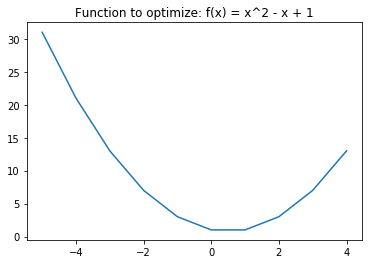

Found minimum after 1000 trials:
{'x': 0.4999737095569216}


In [3]:
%reset -f

from hyperopt import fmin, tpe, hp
import matplotlib.pyplot as plt

def f(x):
    return x**2 - x + 1

plt.plot(range(-5, 5), [f(x) for x in range(-5, 5)])
plt.title("Function to optimize: f(x) = x^2 - x + 1")
plt.show()

space = hp.uniform('x', -5, 5)

best = fmin(
    fn=f,  # "Loss" function to minimize
    space=space,  # Hyperparameter space
    algo=tpe.suggest,  # Tree-structured Parzen Estimator (TPE)
    max_evals=1000  # Perform 1000 trials
)

print("Found minimum after 1000 trials:")
print(best)


## Hyperopt hyperspaces can be represented as nested data structures, too

Yet, we have defined spaces as a single parameter. But that is 1D. Normally, spaces contain many parameters. Let's define a more complex one: 

In [4]:
%reset -f

from hyperopt import pyll, hp

import pprint

pp = pprint.PrettyPrinter(indent=4, width=100)

# Define a complete space: 
space = {
    'x': hp.normal('x', 0, 2),
    'y': hp.uniform('y', 0, 1),
    'use_float_param_or_not': hp.choice('use_float_param_or_not', [
        None, hp.uniform('float', 0, 1),
    ]), 
    'my_abc_other_params_list': [
        hp.normal('a', 0, 2), hp.uniform('b', 0, 3), hp.choice('c', [False, True]),
    ], 
    'yet_another_dict_recursive': {
        'u': hp.uniform('u', 0, 3),
        'v': hp.uniform('v', 0, 3),
        'u': hp.uniform('w', -3, 0)
    }
}

# Print a few random (stochastic) samples from the space: 
for _ in range(10):
    pp.pprint(pyll.stochastic.sample(space))


{   'my_abc_other_params_list': (2.4119150899556074, 0.5702801493499841, False),
    'use_float_param_or_not': None,
    'x': -3.362567945789273,
    'y': 0.28792106075341284,
    'yet_another_dict_recursive': {'u': -0.36963813691500835, 'v': 2.288078569448955}}
{   'my_abc_other_params_list': (0.886943416734673, 2.9807362773468777, True),
    'use_float_param_or_not': 0.6812837431751659,
    'x': 0.9844403220486979,
    'y': 0.3345927898797796,
    'yet_another_dict_recursive': {'u': -0.39858766246643595, 'v': 0.3122970605863584}}
{   'my_abc_other_params_list': (-0.8131772283321974, 2.668119841769504, False),
    'use_float_param_or_not': None,
    'x': 2.265427372259613,
    'y': 0.7580985215938283,
    'yet_another_dict_recursive': {'u': -1.0639299638583357, 'v': 1.4871901275027533}}
{   'my_abc_other_params_list': (-2.047124027785455, 0.2221206922642982, True),
    'use_float_param_or_not': None,
    'x': 4.031132768704749,
    'y': 0.4939424778927832,
    'yet_another_dict_recurs

## Example with a dict hyperparameter space

Let's solve for minimizing f(x, y) = x^2 + y^2.

In [5]:
%reset -f

from hyperopt import fmin, tpe, hp

def f(space):
    x = space['x']
    y = space['y']
    return x**2 + y**2

space = {
    'x': hp.uniform('x', -5, 5),
    'y': hp.uniform('y', -5, 5)
}

best = fmin(
    fn=f,
    space=space,
    algo=tpe.suggest,
    max_evals=1000
)

print("Found minimum after 1000 trials:")
print(best)

Found minimum after 1000 trials:
{'x': -0.007598895745733192, 'y': 0.025546214817589508}


## Let's now record the history of every trial

This will require us to import a few more things, and return the results with a dict that has a "status" and "loss" key at least. Let's keep in our return dict the evaluated space too as this may come in handy if we save results to disk.

In [6]:
%reset -f

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL

import pprint

pp = pprint.PrettyPrinter(indent=4)

def f(space):
    x = space['x']
    y = space['y']
    
    if y > 1:
        # Make use of status fail as an example of skipping on error
        result = {
            "loss": -1,
            "status": STATUS_FAIL,
            "space": space
        }
        return result
    
    loss = x**2 + y**2
    result = {
        "loss": loss, 
        "status": STATUS_OK,
        "space": space
    }
    return result

space = {
    'x': hp.uniform('x', -5, 5),
    'y': hp.uniform('y', -5, 5)
}

trials = Trials()

best = fmin(
    fn=f,
    space=space,
    algo=tpe.suggest,
    trials=trials,
    max_evals=1000
)

print("Found minimum after 1000 trials:")
print(best)
print("")

print("Here are the space and results of the 3 first trials (out of a total of 1000):")
pp.pprint(trials.trials[0])
pp.pprint(trials.trials[1])
pp.pprint(trials.trials[2])
# pp.pprint(trials.trials[...])
# pp.pprint(trials.trials[999])
print("")

print("What interests us most is the 'result' key of each trial (here, we show 7):")
pp.pprint(trials.trials[0]["result"])
pp.pprint(trials.trials[1]["result"])
pp.pprint(trials.trials[2]["result"])
pp.pprint(trials.trials[3]["result"])
pp.pprint(trials.trials[4]["result"])
pp.pprint(trials.trials[5]["result"])
pp.pprint(trials.trials[6]["result"])
# pp.pprint(trials.trials[...]["result"])
# pp.pprint(trials.trials[999]["result"])

Found minimum after 1000 trials:
{'x': -0.4044775795383271, 'y': 0.017543106156265864}

Here are the space and results of the 3 first trials (out of a total of 1000):
{   'book_time': datetime.datetime(2017, 7, 11, 17, 50, 43, 123000),
    'exp_key': None,
    'misc': {   'cmd': ('domain_attachment', 'FMinIter_Domain'),
                'idxs': {'x': [0], 'y': [0]},
                'tid': 0,
                'vals': {'x': [-4.027207903440633], 'y': [3.3570232217786735]},
                'workdir': None},
    'owner': None,
    'refresh_time': datetime.datetime(2017, 7, 11, 17, 50, 43, 123000),
    'result': {   'loss': -1,
                  'space': {'x': -4.027207903440633, 'y': 3.3570232217786735},
                  'status': 'fail'},
    'spec': None,
    'state': 2,
    'tid': 0,
    'version': 0}
{   'book_time': datetime.datetime(2017, 7, 11, 17, 50, 43, 124000),
    'exp_key': None,
    'misc': {   'cmd': ('domain_attachment', 'FMinIter_Domain'),
                'idxs': {'x': [1],

## Up next: saving results to disk while optimizing, and enable to pause and continue a training

Note that the optimization could be parallelized by using MongoDB and storing the trials' state here. Althought this is a built-in feature of hyperopt, let's keep things simple for our examples here. 

Indeed, the TPE algorithm used by the fmin function has state which is stored in the trials and which is useful to narrow the search space dynamically once we have a few trials. It is then interesting to pause and resume a training, and to apply that to a real problem (in our case, a convolutional neural network for solving the CIFAR-100 problem).

This is what's done inside the file optimize.py of the current Git repository. 